In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

EEG_PROJECT_PATH = "."
CHECKPOINT_PATH = os.path.join(EEG_PROJECT_PATH, "checkpoints")
CONFIG_DIR = os.path.join(EEG_PROJECT_PATH, "configs")
DEFAULT_CONFIG = "tta_energy.yaml"

In [ ]:
import yaml

with open(os.path.join(CONFIG_DIR, DEFAULT_CONFIG)) as f:
    config = yaml.safe_load(f)

In [4]:
config

{'source_run': 'src-bcic2a_loso_2023-12-04_14-41-13',
 'tta_method': 'energy_adaptation',
 'continual': False,
 'tta_config': {'alignment': False,
  'averaging_method': 'ema',
  'align_alpha': 0.1,
  'buffer_length': 32,
  'langevin_init': {'series_length': 1000},
  'optimizer': 'Adam',
  'optimizer_kwargs': {'lr': 0.005, 'beta': 0.9, 'weight_decay': 0.0}}}

In [ ]:
import torch
from eeg_otta.models import BaseNet
from eeg_otta.utils.get_datamodule_cls import get_datamodule_cls
from eeg_otta.utils.seed import seed_everything


with open(os.path.join(CHECKPOINT_PATH, config["source_run"], "config.yaml")) as f:
    source_config = yaml.safe_load(f)
device = torch.device(
    "mps"
    if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available() else "cpu"
)

seed_everything(source_config["seed"])

datamodule_cls = get_datamodule_cls(source_config["dataset_name"])
model_cls = BaseNet

Tensorflow not install, you could not use those pipelines
Setting all random seeds to 0, cuda_available=False


In [ ]:
SUBJECT_ID = 1
ckpt_path = os.path.join(
    CHECKPOINT_PATH, config["source_run"], str(SUBJECT_ID), "model-v1.ckpt"
)

model = model_cls.load_from_checkpoint(ckpt_path, map_location=device)

preprocess_modifications = dict(
    batch_size=1,
    alignment=False,
)

datamodule = datamodule_cls(
    source_config["preprocessing"] | preprocess_modifications, subject_ids=[SUBJECT_ID]
)
datamodule.subject_id = SUBJECT_ID
datamodule.prepare_data()
datamodule.setup()

48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events found on stim channel stim
Event IDs: [1 2 3 4]
48 events foun

/home/lhorns/miniconda3/envs/eeg/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function scale is deprecated; will be removed in 0.8.0. Use numpy.multiply inside a lambda function instead.
  warnings.warn(msg, category=FutureWarning)


KeyboardInterrupt: 

In [ ]:
from eeg_otta.utils.get_accuracy import get_accuracy

get_accuracy(model, datamodule.val_dataloader(), device=device)

100%|██████████| 36/36 [00:05<00:00,  7.19it/s]


0.7630208

In [57]:
get_accuracy(model, datamodule.test_dataloader(), device=device)

100%|██████████| 5/5 [00:00<00:00,  6.94it/s]


0.6909722

In [58]:
get_accuracy(model, datamodule.train_dataloader(), device=device)

100%|██████████| 36/36 [00:06<00:00,  5.99it/s]


0.9618056

Train accs:  [0.985243059694767, 0.9427083358168602, 0.9809027835726738, 0.92578125, 0.94921875, 0.9262152761220932, 0.986111119389534, 0.982638880610466, 0.987413190305233]
Val accs:  [0.8255208283662796, 0.5568576380610466, 0.9066840261220932, 0.712673619389534, 0.774305559694767, 0.6480034738779068, 0.852864570915699, 0.8072916716337204, 0.8433159664273262]
Test accs:  [0.6805555820465088, 0.3958333432674408, 0.8402777910232544, 0.5416666865348816, 0.6701388955116272, 0.4930555522441864, 0.7673611044883728, 0.7291666865348816, 0.7465277910232544]
Mean test acc:  0.6516203814082675


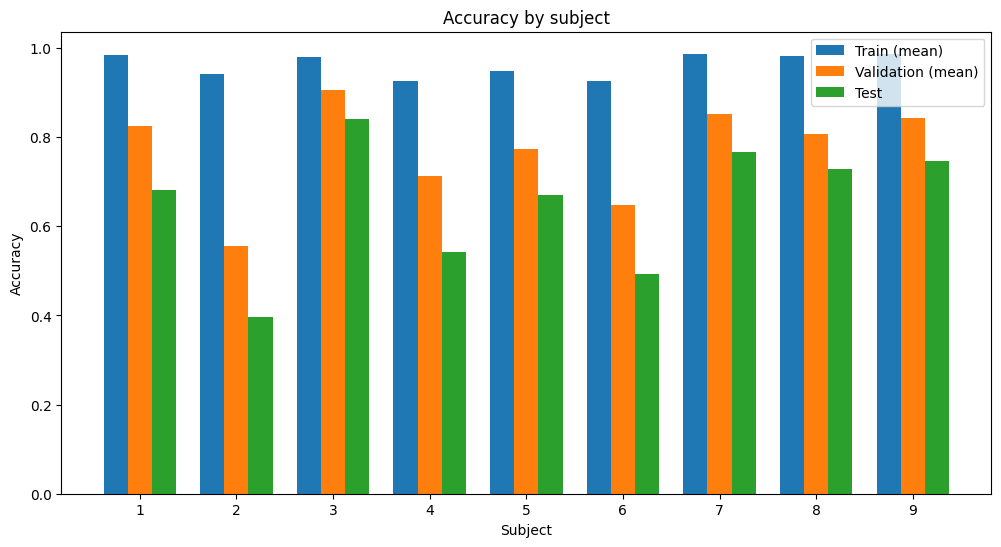

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint

with open("logs/bcic2a_loso-default_subject_accs2.json", "r") as f:
    accuracies = json.load(f)

# pprint(accuracies)

train_accs = []
val_accs = []
test_accs = []

for subject_idx in accuracies.keys():
    train_acc = []
    val_acc = []
    for run_idx, accs in accuracies.items():
        if subject_idx == run_idx:
            test_accs.append(accs["test_acc"][f"subject_{subject_idx}"])
        else:
            train_acc.append(accs["train_acc"][f"subject_{subject_idx}"])
            val_acc.append(accs["val_acc"][f"subject_{subject_idx}"])

    train_accs.append(np.mean(train_acc))
    val_accs.append(np.mean(val_acc))

print("Train accs: ", train_accs)
print("Val accs: ", val_accs)
print("Test accs: ", test_accs)
print("Mean test acc: ", np.mean(test_accs))

categories = accuracies.keys()
x = np.arange(len(categories))  # the label locations
width = 0.25  # the width of the bars
fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, train_accs, width, label="Train (mean)")
rects2 = ax.bar(x, val_accs, width, label="Validation (mean)")
rects3 = ax.bar(x + width, test_accs, width, label="Test")

ax.set_xlabel("Subject")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy by subject")
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

Train accs:  [0.986545130610466, 0.9505208432674408, 0.9835069477558136, 0.9318576380610466, 0.9557291716337204, 0.938368059694767, 0.9882812574505806, 0.978732630610466, 0.9813368022441864]
Val accs:  [0.8307291641831398, 0.6145833283662796, 0.91015625, 0.7113715335726738, 0.7929687649011612, 0.65234375, 0.86328125, 0.8398437425494194, 0.8315972238779068]
Test accs:  [0.7118055820465088, 0.4722222089767456, 0.8645833134651184, 0.6041666865348816, 0.6631944179534912, 0.5451388955116272, 0.7777777910232544, 0.75, 0.7395833134651184]
Mean test acc:  0.6809413565529717


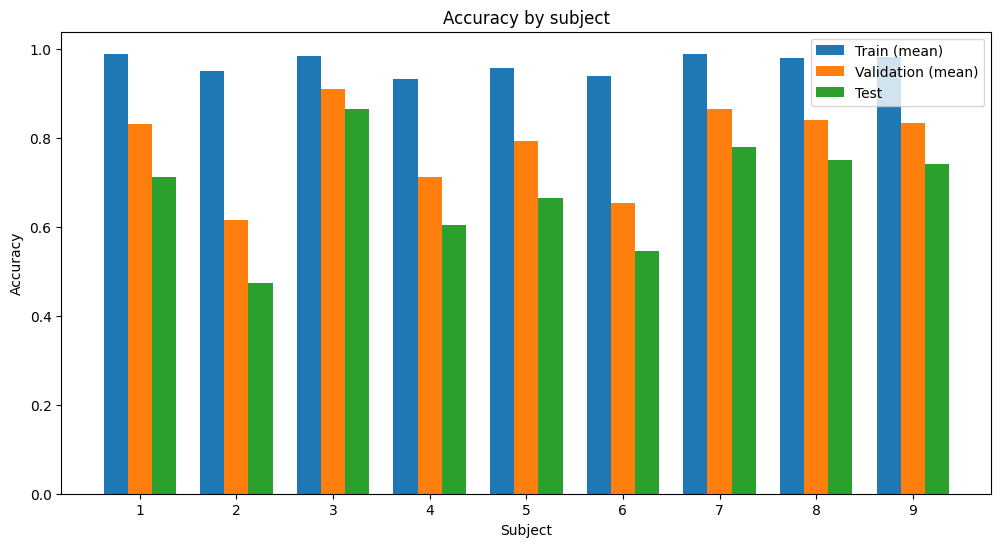

In [ ]:
with open("logs/bcic2a_loso-default_subject_accs-ongoing_norm.json", "r") as f:
    accuracies = json.load(f)

# pprint(accuracies)

train_accs2 = []
val_accs2 = []
test_accs2 = []

for subject_idx in accuracies.keys():
    train_acc = []
    val_acc = []
    for run_idx, accs in accuracies.items():
        if subject_idx == run_idx:
            test_accs2.append(accs["test_acc"][f"subject_{subject_idx}"])
        else:
            train_acc.append(accs["train_acc"][f"subject_{subject_idx}"])
            val_acc.append(accs["val_acc"][f"subject_{subject_idx}"])

    train_accs2.append(np.mean(train_acc))
    val_accs2.append(np.mean(val_acc))

print("Train accs: ", train_accs2)
print("Val accs: ", val_accs2)
print("Test accs: ", test_accs2)
print("Mean test acc: ", np.mean(test_accs2))

categories = accuracies.keys()
x = np.arange(len(categories))  # the label locations
width = 0.25  # the width of the bars
fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, train_accs2, width, label="Train (mean)")
rects2 = ax.bar(x, val_accs2, width, label="Validation (mean)")
rects3 = ax.bar(x + width, test_accs2, width, label="Test")

ax.set_xlabel("Subject")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy by subject")
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

Train accs diff:  0.0031828706463178 [ 0.00130207  0.00781251  0.00260416  0.00607639  0.00651042  0.01215278
  0.00217014 -0.00390625 -0.00607639]
Val accs diff:  0.01326196144024531 [ 0.00520834  0.05772569  0.00347222 -0.00130209  0.01866321  0.00434028
  0.01041668  0.03255207 -0.01171874]
Test accs diff:  0.029320975144704182 [ 0.03125     0.07638887  0.02430552  0.0625     -0.00694448  0.05208334
  0.01041669  0.02083331 -0.00694448]


<BarContainer object of 9 artists>

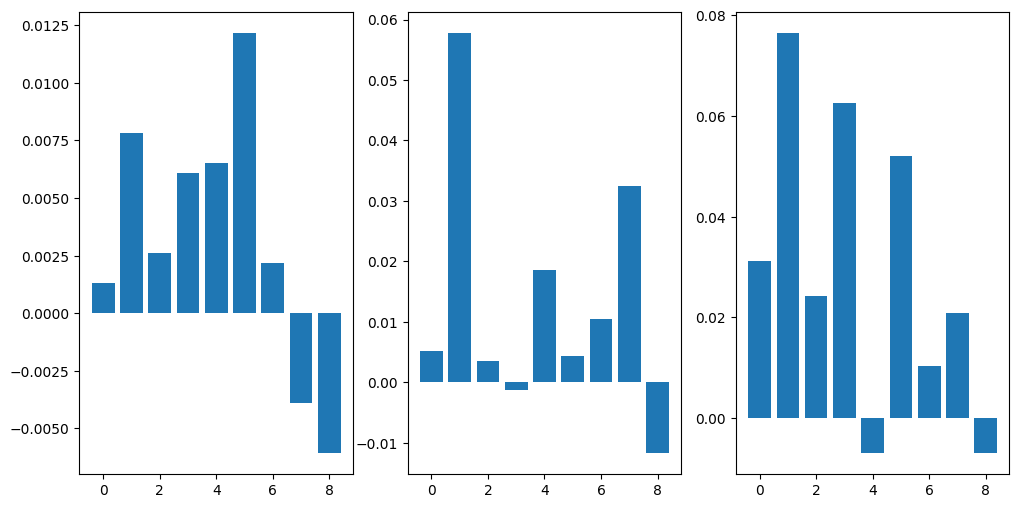

In [ ]:
train_diff = np.array(train_accs2) - np.array(train_accs)
print("Train accs diff: ", np.mean(train_diff), train_diff)

val_diff = np.array(val_accs2) - np.array(val_accs)
print("Val accs diff: ", np.mean(val_diff), val_diff)

test_diff = np.array(test_accs2) - np.array(test_accs)
print("Test accs diff: ", np.mean(test_diff), test_diff)
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].bar(x, train_diff)
ax[1].bar(x, val_diff)
ax[2].bar(x, test_diff)